In [1]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model

In [2]:
def plot_training_curves(history, title=None):
    ''' Plot the training curves for loss and accuracy given a model history
    '''
    # find the minimum loss epoch
    minimum = np.min(history.history['val_loss'])
    min_loc = np.where(minimum == history.history['val_loss'])[0]
    # get the vline y-min and y-max
    loss_min, loss_max = (min(history.history['val_loss'] + history.history['loss']),
                          max(history.history['val_loss'] + history.history['loss']))
    acc_min, acc_max = (min(history.history['val_accuracy'] + history.history['accuracy']),
                        max(history.history['val_accuracy'] + history.history['accuracy']))
    # create figure
    fig, ax = plt.subplots(ncols=2, figsize = (15,7))
    fig.suptitle(title)
    index = np.arange(1, len(history.history['accuracy']) + 1)
    # plot the loss and validation loss
    ax[0].plot(index, history.history['loss'], label = 'loss')
    ax[0].plot(index, history.history['val_loss'], label = 'val_loss')
    ax[0].vlines(min_loc + 1, loss_min, loss_max, label = 'min_loss_location')
    ax[0].set_title('Loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].legend()
    # plot the accuracy and validation accuracy
    ax[1].plot(index, history.history['accuracy'], label = 'accuracy')
    ax[1].plot(index, history.history['val_accuracy'], label = 'val_accuracy')
    ax[1].vlines(min_loc + 1, acc_min, acc_max, label = 'min_loss_location')
    ax[1].set_title('Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].legend()
    plt.show()

In [3]:
# load in the dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [4]:
x_train_0_6 = x_train[y_train < 7] / 255.
y_train_0_6 = y_train[y_train < 7]
x_test_0_6 = x_test[y_test < 7] / 255.
y_test_0_6 = y_test[y_test < 7]

x_train_7_9 = x_train[y_train >= 7] / 255.
y_train_7_9 = y_train[y_train >= 7] - 7
x_test_7_9 = x_test[y_test >= 7] / 255.
y_test_7_9 = y_test[y_test >= 7] - 7

In [5]:
x_train_0_6 = x_train_0_6.reshape(x_train_0_6.shape + (1,))
x_test_0_6 = x_test_0_6.reshape(x_test_0_6.shape + (1,))
x_train_7_9 = x_train_7_9.reshape(x_train_7_9.shape + (1,))
x_test_7_9 = x_test_7_9.reshape(x_test_7_9.shape + (1,))

In [7]:
num_classes=10
filters=32
pool_size=2
kernel_size=3
dropout=0.2
input_shape = (28,28,1)

model = Sequential([
      # convolutional feature extraction
      # ConvNet 1
      keras.layers.Conv2D(filters, kernel_size, padding = 'valid',
              activation='relu',
              input_shape=input_shape),
      keras.layers.MaxPooling2D(pool_size=pool_size),

      # ConvNet 2
      keras.layers.Conv2D(filters, kernel_size,
              padding = 'valid',
              activation='relu'),
      keras.layers.MaxPooling2D(pool_size=pool_size),

      # classification 
      # will retrain from here
      keras.layers.Flatten(name='flatten'),

      keras.layers.Dropout(dropout),
      keras.layers.Dense(128, activation='relu'),
      
      keras.layers.Dropout(dropout, name='penult'),
      keras.layers.Dense(num_classes, activation='softmax', name='last')
  ])

es = keras.callbacks.EarlyStopping(min_delta=0.001, patience=2)

model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

history = model.fit(x_train_0_6, y_train_0_6,
                    validation_data=(x_test_0_6, y_test_0_6),
                    batch_size=32,
                    epochs=1000,
                    callbacks=[es])

Epoch 1/1000
1311/1311 [==============================] - 26s 20ms/step - loss: 0.1233 - accuracy: 0.9614 - val_loss: 0.0340 - val_accuracy: 0.9886
Epoch 2/1000
1311/1311 [==============================] - 27s 21ms/step - loss: 0.0377 - accuracy: 0.9881 - val_loss: 0.0206 - val_accuracy: 0.9936
Epoch 3/1000
1311/1311 [==============================] - 24s 18ms/step - loss: 0.0288 - accuracy: 0.9913 - val_loss: 0.0228 - val_accuracy: 0.9931
Epoch 4/1000
1311/1311 [==============================] - 23s 17ms/step - loss: 0.0247 - accuracy: 0.9923 - val_loss: 0.0163 - val_accuracy: 0.9953
Epoch 5/1000
1311/1311 [==============================] - 23s 17ms/step - loss: 0.0200 - accuracy: 0.9935 - val_loss: 0.0170 - val_accuracy: 0.9943
Epoch 6/1000
1311/1311 [==============================] - 24s 18ms/step - loss: 0.0155 - accuracy: 0.9950 - val_loss: 0.0209 - val_accuracy: 0.9933


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dropout (Dropout)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

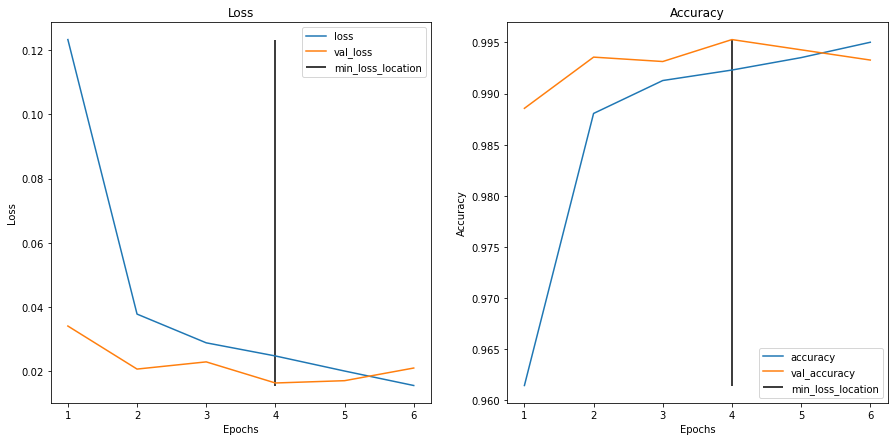

In [9]:
plot_training_curves(history=history)

In [10]:
layer_trainable = False
for layer in model.layers:
  layer.trainable = layer_trainable
  if layer.name == 'flatten':
    layer_trainable = True

print(f"{'Layer Name':17} {'Is Trainable?'}")
for layer in model.layers:
  print(f"{layer.name:17} {layer.trainable}")

Layer Name        Is Trainable?
conv2d            False
max_pooling2d     False
conv2d_1          False
max_pooling2d_1   False
flatten           False
dropout           True
dense             True
penult            True
last              True


In [11]:
# get the penultimate layer of the model
penult_layer = model.get_layer(name='penult')

# create a new output layer
output_layer = keras.layers.Dense(3, activation='softmax')(penult_layer.output)

new_model = Model(model.input, output_layer)

In [12]:
new_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dropout (Dropout)            (None, 800)              

In [13]:
new_model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

new_model_hist = new_model.fit(x_train_7_9, y_train_7_9,
                              validation_data=(x_test_7_9, y_test_7_9),
                              batch_size=32,
                              epochs=1000,
                              callbacks=[es])

Epoch 1/1000
565/565 [==============================] - 4s 7ms/step - loss: 0.1036 - accuracy: 0.9644 - val_loss: 0.0227 - val_accuracy: 0.9914
Epoch 2/1000
565/565 [==============================] - 4s 6ms/step - loss: 0.0340 - accuracy: 0.9890 - val_loss: 0.0184 - val_accuracy: 0.9937
Epoch 3/1000
565/565 [==============================] - 4s 7ms/step - loss: 0.0240 - accuracy: 0.9916 - val_loss: 0.0148 - val_accuracy: 0.9954
Epoch 4/1000
565/565 [==============================] - 4s 7ms/step - loss: 0.0188 - accuracy: 0.9941 - val_loss: 0.0147 - val_accuracy: 0.9937
Epoch 5/1000
565/565 [==============================] - 4s 6ms/step - loss: 0.0143 - accuracy: 0.9954 - val_loss: 0.0190 - val_accuracy: 0.9927


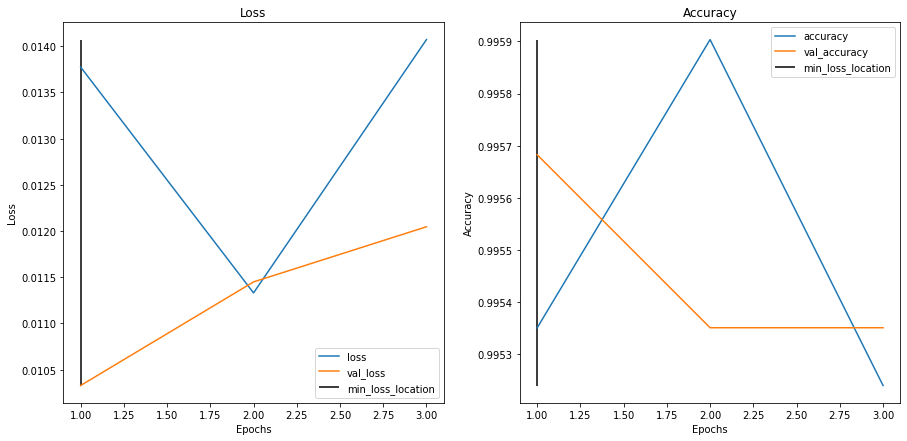

In [16]:
plot_training_curves(new_model_hist)